In [30]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
plotly()

Plots.PlotlyBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [31]:
pdb = "4uet"
# Leo modos
modes_4uet, evals_4uet = JUMD.read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4uet))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_4uet = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4uet = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4uet = (ndd_out_4uet .- vol_avg_4uet) .* evals_4uet
vgv_4uet = vgv_4uet ./ norm(vgv_4uet);

### Obtiene los aa's del hueco

In [4]:
# VGV cartesiano
xyz_vgv_4uet = JUMD.tognm(modes_4uet * vgv_4uet)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_4uet = JUMD.get_pnum(xyz_vgv_4uet)

# Índices de pnumber aminoácidos
idx_cut_4uet = sort(sortperm(abs.(xyz_vgv_4uet), rev = true)[1:cut_4uet])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_4uet_3 = Array{Int64}(undef, length(idx_cut_4uet) * 3)
for i = 1:length(idx_cut_4uet)
    idx_cut_4uet_3[3*i-2] = idx_cut_4uet[i] * 3 - 2
    idx_cut_4uet_3[3*i-1] = idx_cut_4uet[i] * 3 - 1
    idx_cut_4uet_3[3*i] = idx_cut_4uet[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [5]:
# Pnumber de VGV
vgv_pnu_4uet = JUMD.get_pnum(vgv_4uet)

# Pnumber indices
idx_vgv_pnu_4uet = sortperm(abs.(vgv_4uet), rev=true)[1:vgv_pnu_4uet]

# Pnumber modes
modes_pnu_4uet = modes_4uet[:, idx_vgv_pnu_4uet]

# Pnumber eigenvalues
evals_pnu_4uet = evals_4uet[idx_vgv_pnu_4uet];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_4uet = modes_4uet[idx_cut_4uet_3, :]
modes_cut_4uet = mapslices(x -> x ./ norm(x), modes_cut_4uet, dims = 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_4uet = modes_pnu_4uet[idx_cut_4uet_3, :]
modes_pnu_cut_4uet = mapslices(x -> x ./ norm(x), modes_pnu_cut_4uet, dims = 1);

### κ

In [6]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_4uet, dims = 1), dims = 1)))
κ_modes_4uet = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_pnu_4uet, dims = 1), dims = 1)))
κ_modes_pnu_4uet  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_cut_4uet, dims = 1),dims =  1)
κ_modes_cut_4uet  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_pnu_cut_4uet, dims = 1), dims = 1)
κ_modes_pnu_cut_4uet = reshape(tmp, length(tmp));

### Pnumber

In [8]:
# Pnumber de modos enteros
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_4uet, dims = 1), dims = 1)
col_modes_4uet = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_pnu_4uet, dims = 1), dims = 1)
col_modes_pnu_4uet = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_cut_4uet, dims = 1), dims = 1)
col_modes_cut_4uet = reshape(tmp, length(tmp))  ./ cut_4uet

# Pnumber de pnum modos cut
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_pnu_cut_4uet, dims = 1), dims = 1)
col_modes_pnu_cut_4uet = reshape(tmp, length(tmp))  ./ cut_4uet;

## Frecuencia

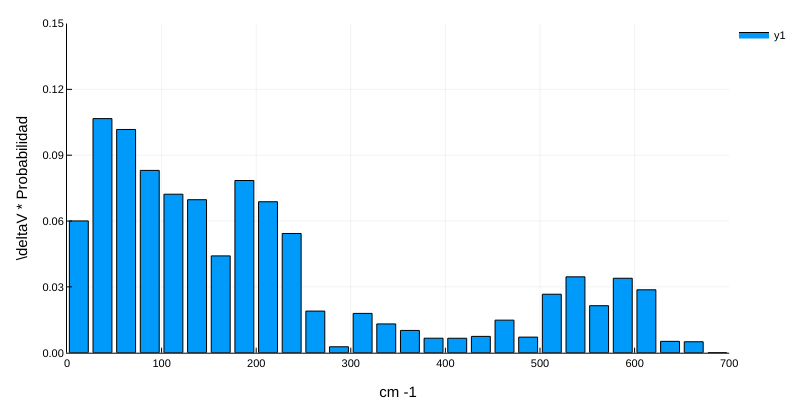

In [10]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_4uet)
bins_evals = collect(0:25:700)

# Histograma ponderado
Wbins_evals_4uet, Whis_evals_4uet = JUMD.WeightedHist(evals_4uet, bins_evals, abs.(vgv_4uet),
    true, false);

bar(Wbins_evals_4uet, Whis_evals_4uet,
    xlims = (0, 700), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "cm -1")

## Colectividad

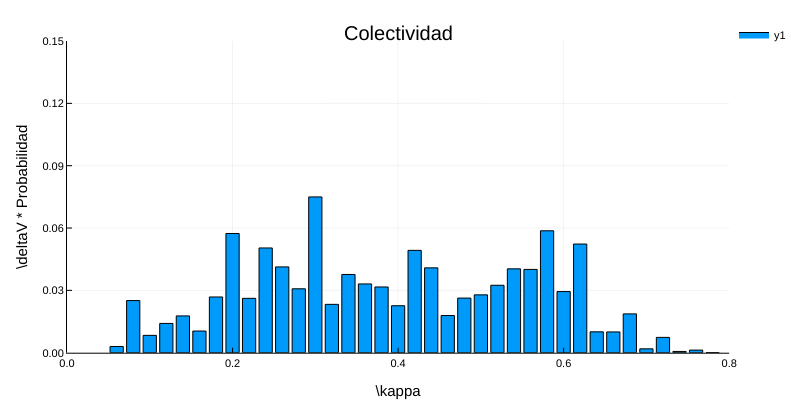

In [11]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_4uet)
bins_κ = collect(0.05:.02:.8)

# Histograma ponderado
Wbins_κ_4uet, Whis_κ_4uet = JUMD.WeightedHist(κ_modes_4uet, bins_κ, abs.(vgv_4uet),
    true, false);

bar(Wbins_κ_4uet, Whis_κ_4uet,
    title = "Colectividad",
    xlims = (0, .8), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

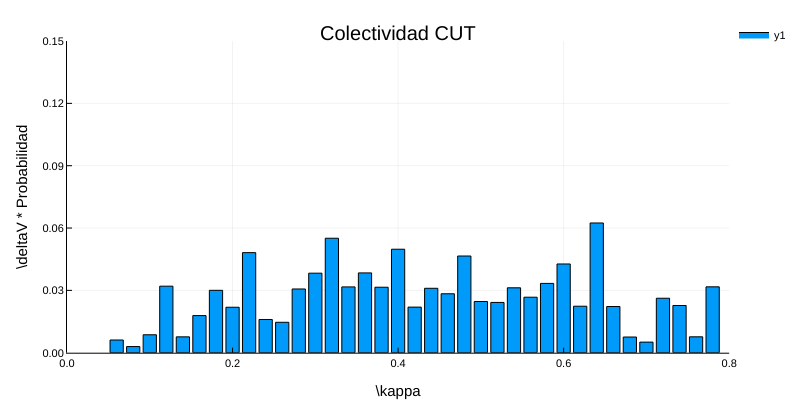

In [12]:
Wbins_κ_cut_4uet, Whis_κ_cut_4uet = JUMD.WeightedHist(κ_modes_cut_4uet, bins_κ, abs.(vgv_4uet), true);

bar(Wbins_κ_cut_4uet, Whis_κ_cut_4uet,
    title = "Colectividad CUT",
    xlims = (0, .8), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

### Colectividad en pnumber

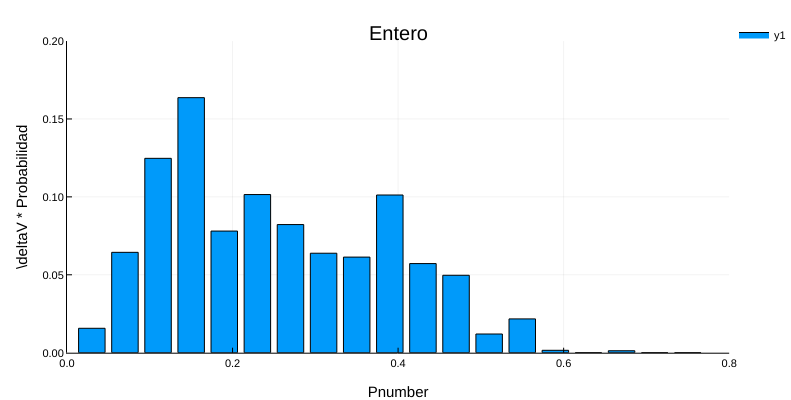

In [13]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_4uet)
bins_col = collect(0.01:.04:.8)

# Histograma ponderado
Wbins_col_4uet, Whis_col_4uet = JUMD.WeightedHist(col_modes_4uet, bins_col, abs.(vgv_4uet),
    true, false);

bar(Wbins_col_4uet, Whis_col_4uet,
    xlims = (0., .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Entero")

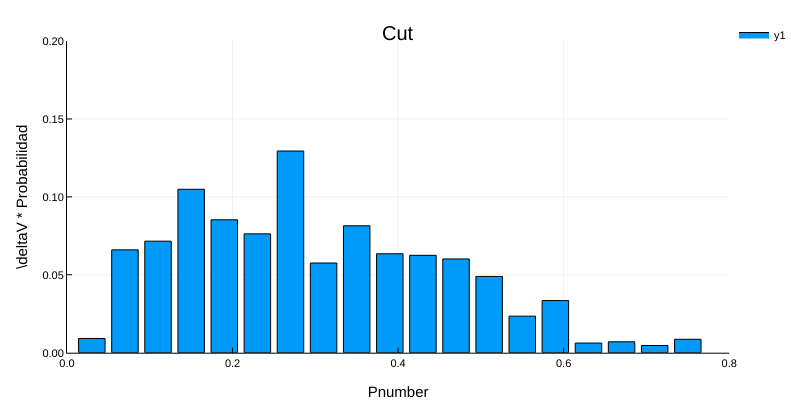

In [14]:
# Uso los bins de arriba
# Histograma ponderado
Wbins_col_cut_4uet, Whis_col_cut_4uet = JUMD.WeightedHist(col_modes_cut_4uet, bins_col, abs.(vgv_4uet),
    true, false);

bar(Wbins_col_cut_4uet, Whis_col_cut_4uet,
    xlims = (0., .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Cut")

## AAs de la pared

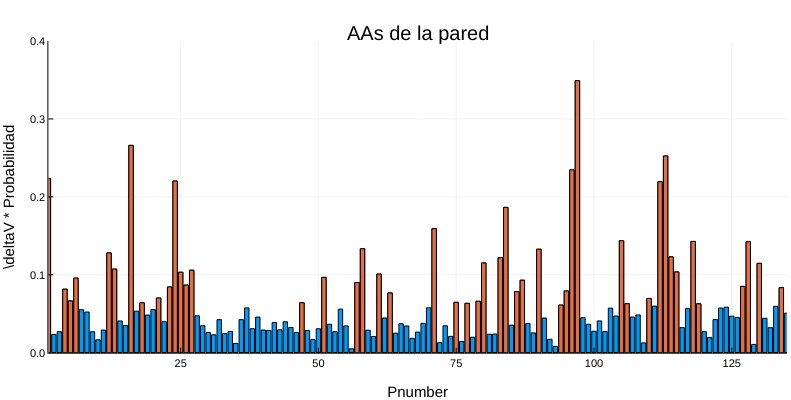

In [15]:
tmp = abs.(xyz_vgv_4uet)
tmp_ = copy(tmp)
tmp_[tmp_ .< .06] .= 0.;

bar(tmp,
    xlims = (1, 135), ylims = (0, .4),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "AAs de la pared",
    legend = false, size = (750, 400))
bar!(tmp_)

## Volumen de la trayectoria

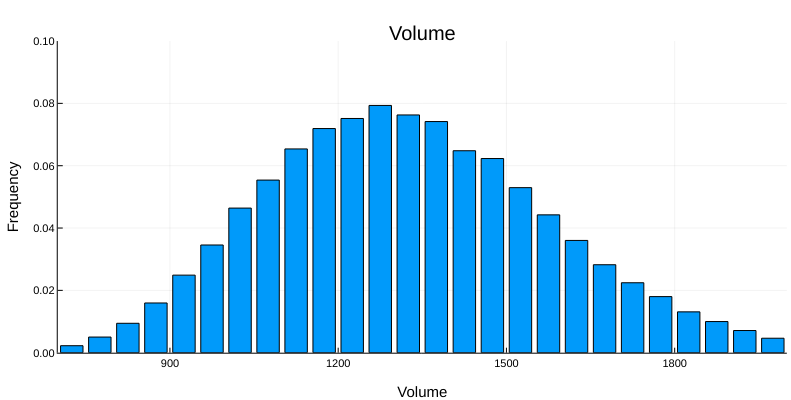

In [17]:
bin_vol = collect(700:50:2000)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_4uet, Whis_vol_4uet = JUMD.WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_4uet, Whis_vol_4uet,
    xlims = (700, 2000), ylims = (0, .1),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = false, size = (750, 400))

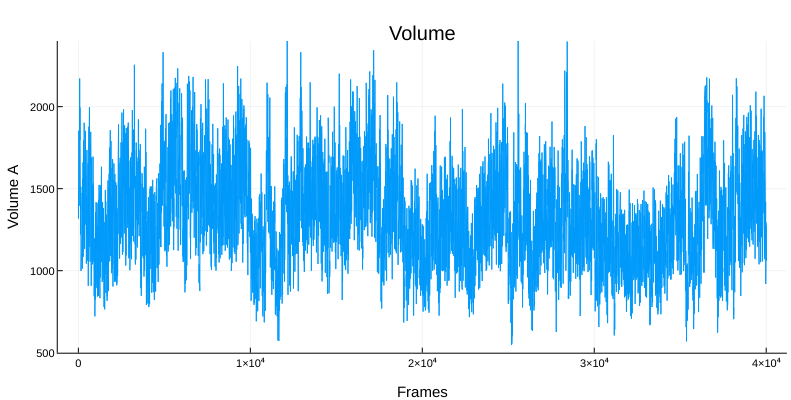

In [18]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    ylims = (500, 2400),
    legend = false, size = (750, 400))

In [19]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1326.4312032999999
  255.927637998458 

## Energía

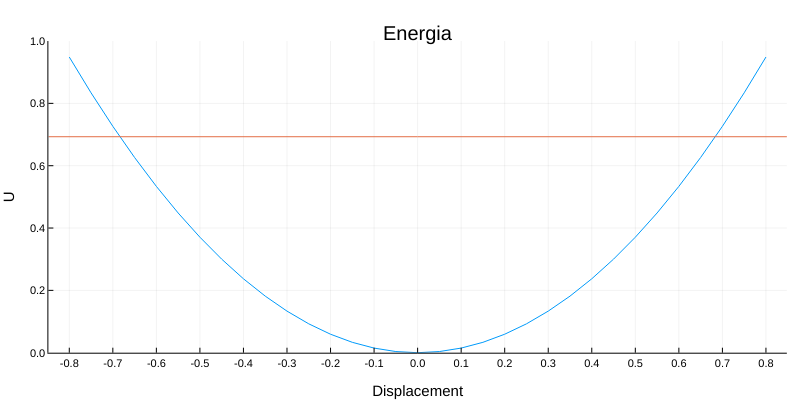

In [51]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_4uet = Array{Float64,1}(undef, npasos)
i = 0
for d in pasos
    i+=1
    E_4uet[i] = JUMD.energia_gdte(evals_4uet, vgv_4uet, d)
end

plot(pasos, E_4uet,
    yaxis = "U", xaxis = "Displacement", title = "Energia",
    xticks = -.8:.1:.8,
    ylims = (0, 1.),
    legend = false, size = (750, 400))
hline!([RT])

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

dif = diff_trj_avg(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")),
    joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    collect(10:144))

fid = h5open(joinpath(rtdos, string("diff_", pdb, ".h5")), "w")
write(fid, "dif",dif)
close(fid)

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [26]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_4uet = Array{Float64, 1}(undef, nframes)
prj_2_4uet = Array{Float64, 1}(undef, nframes)
prj_3_4uet = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_4uet[i] = dot(norm_dif[:, i], modes_4uet[:, 1])
    prj_2_4uet[i] = dot(norm_dif[:, i], modes_4uet[:, 2])
    prj_3_4uet[i] = dot(norm_dif[:, i], modes_4uet[:, 3])
end

# Smooth
smooth_prj_1_4uet = [ mean(prj_1_4uet[i:i+9]) for i = 1:10:length(prj_1_4uet)-9 ]
smooth_prj_2_4uet = [ mean(prj_2_4uet[i:i+9]) for i = 1:10:length(prj_2_4uet)-9 ]
smooth_prj_3_4uet = [ mean(prj_3_4uet[i:i+9]) for i = 1:10:length(prj_3_4uet)-9 ];

┌ Warning: Deprecated syntax `implicit assignment to global variable `i``.
│ Use `global i` instead.
└ @ nothing none:0
┌ Warning: Loop variable `i` around In[26]:8 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[26]:8


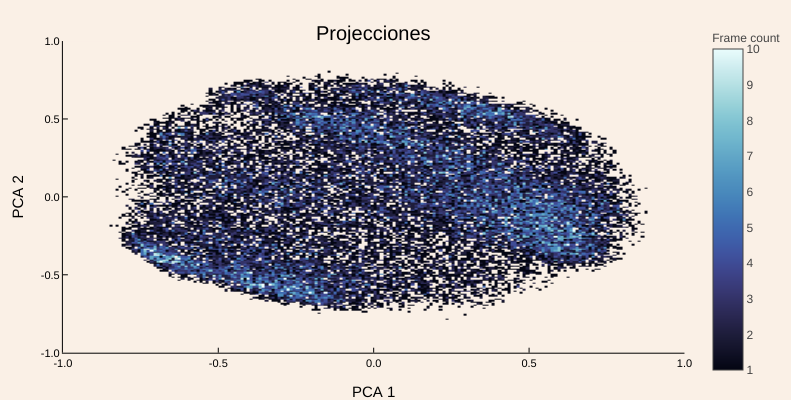

In [28]:
plt_2his = histogram2d(smooth_prj_1_4uet, smooth_prj_2_4uet, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "Projecciones",
    clims = (1, 10), colorbar_title = "Frame count",
    linealpha = 0,
    nbins = 200, seriescolor = :ice,
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen)

In [33]:
savefig(plt_2his, joinpath(rtdos, "papel", string("2_plt_2his_", pdb, ".svg")))

MethodError: MethodError: no method matching _show(::IOStream, ::MIME{Symbol("image/svg+xml")}, ::Plots.Plot{Plots.PlotlyBackend})
Closest candidates are:
  _show(::IO, !Matched::MIME{Symbol("text/html")}, ::Plots.Plot{Plots.PlotlyBackend}) at /home/german/.julia/packages/Plots/ex9On/src/backends/plotly.jl:919
  _show(::IO, !Matched::MIME{Symbol("text/html")}, ::Plots.Plot) at /home/german/.julia/packages/Plots/ex9On/src/output.jl:171
  _show(::IO, !Matched::MIME{Symbol("text/plain")}, ::Plots.Plot) at /home/german/.julia/packages/Plots/ex9On/src/output.jl:212
  ...

marcos_pnu = Array{Int64, 1}(undef, nframes)
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)

for i = 1:nframes
    tmp = reshape(mapslices(x->dot(x, norm_dif[:, i]), modes_4uet, dims = 1), aa3)
    marcos_pnu[i] = JUMD.get_pnum(tmp)
    marcos_modos[i] = sortperm(abs.(tmp), rev = true)[1:marcos_pnu[i]]
end

# Guardo los pnumbers
fid = h5open(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "w")
write(fid, "pnu", marcos_pnu)
close(fid)

# Guardo los pnumbers modos de c/ frame
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "w")
for i = 1:nframes
    write(fid, string("frame_", i), marcos_modos[i])
end
close(fid)

In [ ]:
savefig(plt_2his, joinpath(rtdos, "papel",  "2", string("2_hispn_", pdb, ".svg")))

In [ ]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "r")
for i = 1:nframes
    marcos_modos[i] = read(fid, string("frame_", i))
end
close(fid)
flat_marcos_modos = collect(Iterators.flatten(marcos_modos))

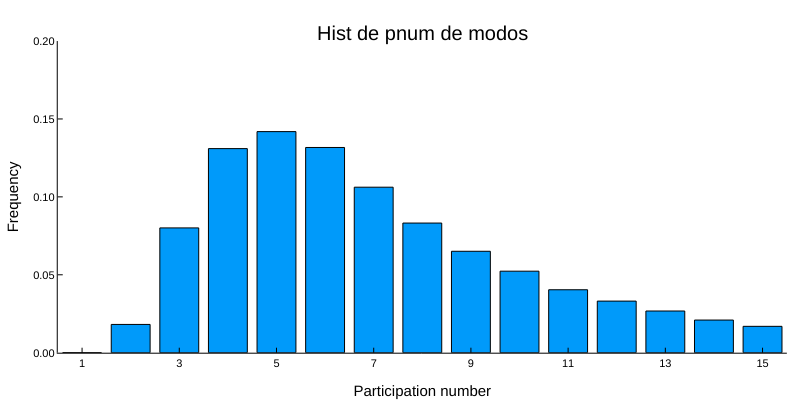

In [49]:
bin_vol = collect(1:1:25)
wgh_vol = fill(1.0, length(marcos_pnu))

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.WeightedHist(marcos_pnu, bin_vol, wgh_vol, true, false);

plt_his_marcos_pnu = bar(bins_marcos_pnu .- .5 , his_marcos_pnu,
    ylims = (0, .2), xlims = (.5, 15.5),
    xticks = 1:2:15, yticks = 0:.05:.2,
    grid = false,
    yaxis = "Frequency", xaxis = "Participation number", title = "Hist de pnum de modos",
    legend = false, size = (750, 400))

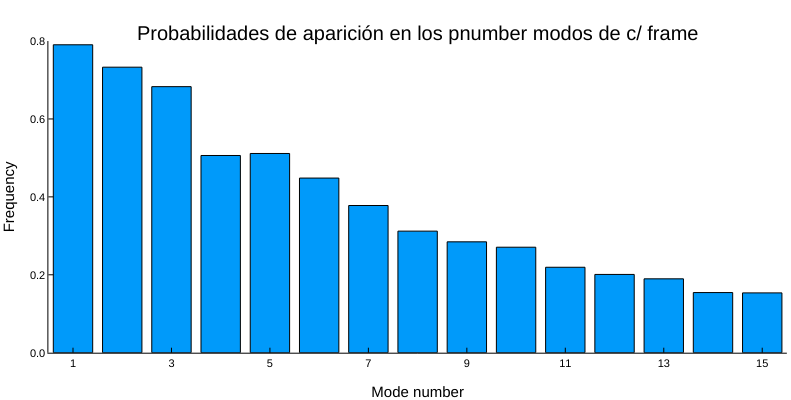

In [50]:
bin_mod = collect(1:1:25)
wgh_mod = fill(1 / nframes, length(flat_marcos_modos))

# Histograma ponderado
bins_marcos_mod, his_marcos_mod = JUMD.WeightedHist(flat_marcos_modos, bin_mod, wgh_mod, false, false);

plt_his_marcos_mod = bar(bins_marcos_mod .- .5, his_marcos_mod,
    ylims = (0, .8), xlims = (.5, 15.5),
    xticks = 1:2:15, yticks = 0:.2:.8,
    grid = false,
    yaxis = "Frequency", xaxis = "Mode number",
    title = "Probabilidades de aparición en los pnumber modos de c/ frame",
    legend = false, size = (750, 400))

In [43]:
savefig(plt_2his, joinpath(rtdos, "papel",  "2", string("2_pnmod_", pdb, ".svg")))